<div align="center">

#### Lab 3

# National Tsing Hua University

#### Spring 2024

#### 11220IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 3: Anomaly Detection in Industrial Applications

</div>

### Introduction

In today's industrial landscape, the ability to detect anomalies in manufacturing processes and products is critical for maintaining quality, efficiency, and safety. This lab focuses on leveraging deep learning techniques for anomaly detection in various industrial applications, using the MVTEC Anomaly Detection Dataset. By employing ImageNet-pretrained models available in torchvision, students will gain hands-on experience in classfying defects and irregularities across different types of industrial products.

Throughout this lab, you'll be involved in the following key activities:
- Explore and process the MVTec Anomaly Detection Dataset.
- Apply ImageNet-pretrained models from [Torchvision](https://pytorch.org/vision/stable/models.html) to detect anomalies in industrial products.
- Evaluate the performance of the models to understand their effectiveness in real-world industrial applications.

### Objectives

- Understand the principles of anomaly detection in the context of industrial applications.
- Learn how to implement and utilize ImageNet-pretrained models for detecting anomalies.
- Analyze and interpret the results of the anomaly detection models to assess their practicality in industrial settings.

### Dataset

The MVTec AD Dataset is a comprehensive collection of high-resolution images across different categories of industrial products, such as bottles, cables, and metal nuts, each with various types of defects. This dataset is pivotal for developing and benchmarking anomaly detection algorithms. You can download our lab's dataset [here](https://drive.google.com/file/d/19600hUOpx0hl78TdpdH0oyy-gGTk_F_o/view?usp=share_link). You can drop downloaded data and drop to colab, or you can put into yor google drive.

### References
- [MVTec AD Dataset](https://www.kaggle.com/datasets/ipythonx/mvtec-ad/data) for the dataset used in this lab.
- [Torchvision Models](https://pytorch.org/vision/stable/models.html) for accessing ImageNet-pretrained models to be used in anomaly detection tasks.
- [State-of-the-Art Anomaly Detection on MVTec AD](https://paperswithcode.com/sota/anomaly-detection-on-mvtec-ad) for insights into the latest benchmarks and methodologies in anomaly detection applied to the MVTec AD dataset.
- [CVPR 2019: MVTec AD — A Comprehensive Real-World Dataset for Unsupervised Anomaly Detection] for the original paper of MVTec AD dataset.

In [1]:
import glob
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm
import cv2
import numpy as np

In [2]:
from google.colab import drive

drive.mount('/content/drive')
!unzip drive/MyDrive/DL_HW/hazelnut.zip #要解壓縮（傳到drive上）/content/drive/MyDrive/DL_HW/hazelnut.zip

Mounted at /content/drive
Archive:  drive/MyDrive/DL_HW/hazelnut.zip
   creating: hazelnut/crack/
  inflating: hazelnut/crack/000.png  
  inflating: hazelnut/crack/001.png  
  inflating: hazelnut/crack/002.png  
  inflating: hazelnut/crack/003.png  
  inflating: hazelnut/crack/004.png  
  inflating: hazelnut/crack/005.png  
  inflating: hazelnut/crack/006.png  
  inflating: hazelnut/crack/007.png  
  inflating: hazelnut/crack/008.png  
  inflating: hazelnut/crack/009.png  
  inflating: hazelnut/crack/010.png  
  inflating: hazelnut/crack/011.png  
  inflating: hazelnut/crack/012.png  
  inflating: hazelnut/crack/013.png  
  inflating: hazelnut/crack/014.png  
  inflating: hazelnut/crack/015.png  
  inflating: hazelnut/crack/016.png  
  inflating: hazelnut/crack/017.png  
   creating: hazelnut/cut/
  inflating: hazelnut/cut/000.png    
  inflating: hazelnut/cut/001.png    
  inflating: hazelnut/cut/002.png    
  inflating: hazelnut/cut/003.png    
  inflating: hazelnut/cut/004.png    
 

In [3]:
file_paths = glob.glob('hazelnut/*/*.png')#所有的png檔的路徑取出
file_paths = sorted([path for path in file_paths if path.split('/')[-1] in [f'{i:03}.png' for i in range(10)]])
#good類別特別多，所以只取每一類10張（000.png～009.png)
print(len(file_paths))

50


In [4]:
all_data = []#此dataset量很少

for img in tqdm(file_paths):#去讀取出來的所有圖片（tqdm可以看到進度條）
    img = cv2.imread(img)
    img = img[..., ::-1]#cv2讀進來的圖是BGR（反的）要轉過來變RGB
    all_data.append(img)

all_data = np.stack(all_data)#轉成numpy
print(all_data.shape)

  0%|          | 0/50 [00:00<?, ?it/s]

(50, 1024, 1024, 3)


Classes: ['crack', 'cut', 'good', 'hole', 'print']


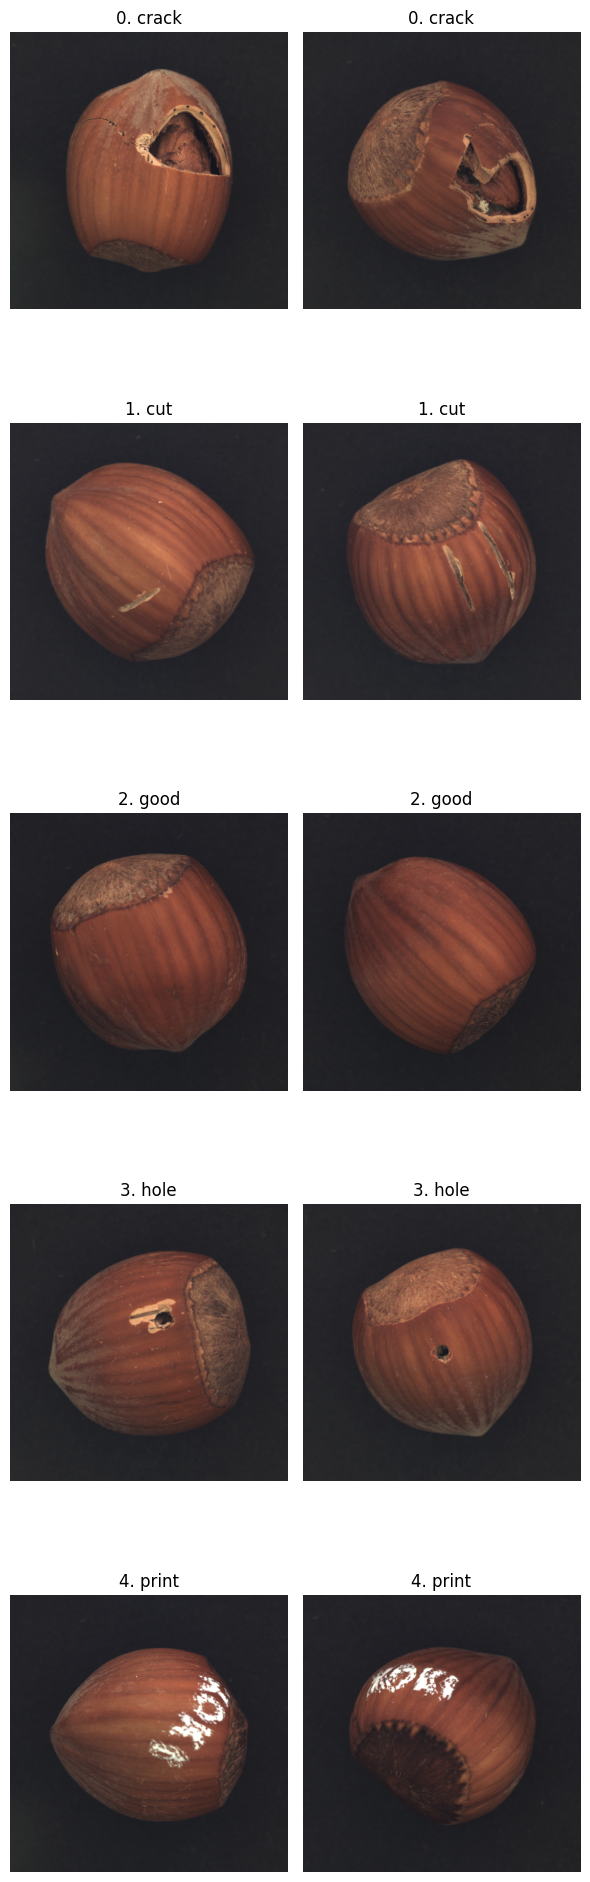

In [5]:
import matplotlib.pyplot as plt
import numpy as np

classes = sorted(set([path.split('/')[1] for path in file_paths]))#第2個folder是命名種類（已知）
print(f'Classes: {classes}')

images_per_class = len(all_data) // len(classes)
fig, axs = plt.subplots(len(classes), 2, figsize=(6, 4 * len(classes)))

for i, class_name in enumerate(classes):#印出圖共5類榛果
    index = i * images_per_class
    for j in range(2):
        axs[i, j].set_title(f'{i}. {class_name}')
        axs[i, j].imshow(all_data[index + j])
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

## A. Data Loading and Preprocessing

In [6]:
!pip uninstall numpy
!pip install -U numpy

Found existing installation: numpy 1.25.2
Uninstalling numpy-1.25.2:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.10
    /usr/local/lib/python3.10/dist-packages/numpy-1.25.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-5007b62f.3.23.dev.so
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.10/dist-packages/numpy/*
Proceed (Y/n)? Y
  Successfully uninstalled numpy-1.25.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 36.6 MB/s eta 0:00:00


In [7]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split


num_classes = 5
images_per_class = 10
train_images_per_class = int(images_per_class * 0.8)#沒有test
val_images_per_class = int(images_per_class * 0.2)

x_train = []
x_val = []

#10張第零類、10張第一類⋯⋯（每個都要分成80%/20%）
for i in range(num_classes):
    start_index = i * images_per_class
    x_train.extend(all_data[start_index:start_index + train_images_per_class])
    x_val.extend(all_data[start_index + train_images_per_class:start_index + images_per_class])

# The shape changes from (batch_size, height, width, channels)～（80，1024，1024，3） to (batch_size, channels, height, width)
x_train = np.transpose(np.array(x_train), (0, 3, 1, 2))
x_val = np.transpose(np.array(x_val), (0, 3, 1, 2))

y_train = np.concatenate([np.full(train_images_per_class, i) for i in range(num_classes)])
y_val = np.concatenate([np.full(val_images_per_class, i) for i in range(num_classes)])

print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_val: {x_val.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_val: {y_val.shape}')

Shape of x_train: (40, 3, 1024, 1024)
Shape of x_val: (10, 3, 1024, 1024)
Shape of y_train: (40,)
Shape of y_val: (10,)


In [25]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

train_transforms = transforms.Compose(
    [
        transforms.Resize((32, 32)),#可變動
        transforms.AutoAugment(),#dataAugmentation
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),#重要：可以把numpy轉成tensor
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ]
)

class MyDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = torch.from_numpy(y).long()
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        new_x = np.transpose(self.x[idx], (1, 2, 0))
        return self.transform(Image.fromarray(new_x)), self.y[idx]

In [58]:
batch_size = 16

train_dataset = MyDataset(x_train, y_train, train_transforms)
val_dataset = MyDataset(x_val, y_val, val_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True, persistent_workers=True)

## B. Defining Neural Networks

In [59]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

#model = models.resnet18(weights='IMAGENET1K_V1')#重點：torch vision可以把ResNet改成別的
model = models.mobilenet_v2(weights='IMAGENET1K_V1')

# ConvNet as fixed feature extractor (freeze parameters)
for param in model.parameters():
    param.requires_grad = False

#num_ftrs = model.fc.in_features
num_ftrs = 1280
num_class = 5#五個類別

# change # of class from 1000 into 5 in the last layer
#model.fc = nn.Linear(num_ftrs, num_class)#最後一層名字可能不一樣（print出來看看，不一定是fc）
model.classifier = nn.Linear(num_ftrs, num_class)
print(model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

## C. Training the Neural Network

In [60]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 70
#model = model.cuda()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

best_val_loss = float('inf')
best_val_acc = -1

#softmax = nn.Softmax()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        images = images.to(device)
        #images = images.cuda()
        images = (images) / 255.#normalize(圖片最大值255）
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        labels = labels.to(device)
        #labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)

        labels = labels.long()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = outputs.argmax(-1)
        train_correct += (train_predicted == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            images = images.to(device)
            #images = images.cuda()
            images = (images) / 255.
            labels = labels.to(device)
            #labels = labels.cuda()
            outputs = model(images)

            labels = labels.long()

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = outputs.argmax(-1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'model_classification.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.4f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.4f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 1/70, Train loss: 1.7406, Train acc: 17.5000%, Val loss: 1.6107, Val acc: 20.0000%, Best Val loss: 1.6107 Best Val acc: 20.00%
Epoch 2/70, Train loss: 1.4469, Train acc: 40.0000%, Val loss: 1.6106, Val acc: 30.0000%, Best Val loss: 1.6106 Best Val acc: 30.00%
Epoch 3/70, Train loss: 1.4114, Train acc: 27.5000%, Val loss: 1.6113, Val acc: 20.0000%, Best Val loss: 1.6106 Best Val acc: 30.00%
Epoch 4/70, Train loss: 1.3606, Train acc: 55.0000%, Val loss: 1.6295, Val acc: 20.0000%, Best Val loss: 1.6106 Best Val acc: 30.00%
Epoch 5/70, Train loss: 1.3240, Train acc: 50.0000%, Val loss: 1.6416, Val acc: 20.0000%, Best Val loss: 1.6106 Best Val acc: 30.00%
Epoch 6/70, Train loss: 1.2976, Train acc: 45.0000%, Val loss: 1.7073, Val acc: 20.0000%, Best Val loss: 1.6106 Best Val acc: 30.00%
Epoch 7/70, Train loss: 1.3153, Train acc: 42.5000%, Val loss: 1.7040, Val acc: 20.0000%, Best Val loss: 1.6106 Best Val acc: 30.00%
Epoch 8/70, Train loss: 1.1781, Train acc: 55.0000%, Val loss: 1.6969

### Visualizing model performance

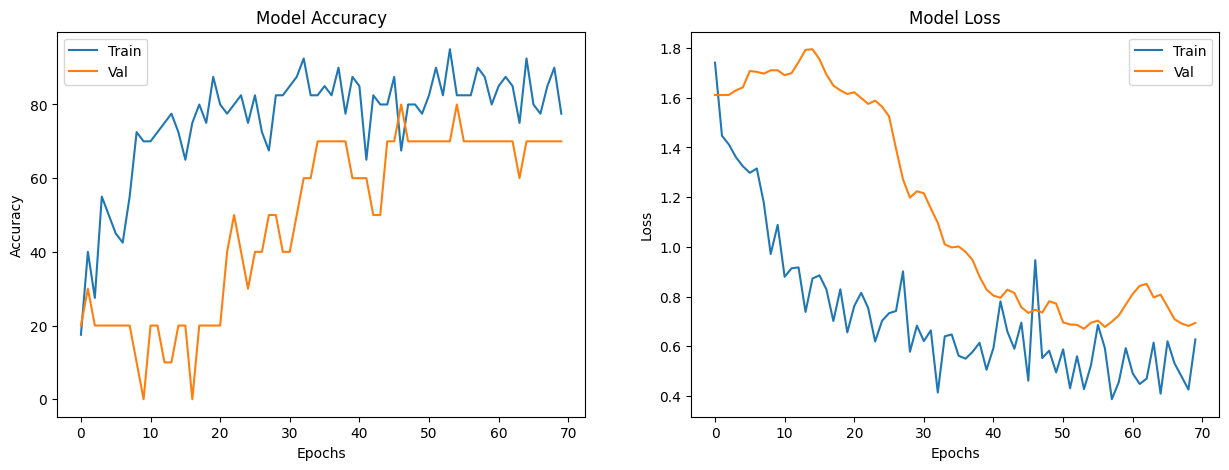

In [61]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

### Load Trained Model and Evaluate

In [62]:
# Load the trained weights
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in val_loader:#沒有test的dataset
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        images = images.to(device)
        #images = images.cuda()
        images = (images) / 255.

        labels = labels.to(device)
        #labels = labels.cuda()
        labels = labels.long()

        outputs = model(images)

        predicted = outputs.argmax(-1)
        print(predicted)
        print(labels)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')

tensor([0, 0, 0, 1, 2, 2, 3, 3, 4, 2])
tensor([0, 0, 1, 1, 2, 2, 3, 3, 4, 4])
Test accuracy is 80.0%
